# Developing a three pool model

## Imports and Load Data

In [1]:
import pandas as pd
import numpy as np
import sys, os
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
from MetaIPM import network
from MetaIPM import populated_network
from MetaIPM import stochastic_wrapper as sw
from MetaIPM import summarize_outputs as so
from MetaIPM import recruitment
import matplotlib as mpl
import cycler

data_file_path = "./ModelData/"
graphics = "./Graphics/"

In [2]:
network_file = "network.csv"
transition_probs = "psi2.csv"
transition_key = "psi_key2.csv"
node_file = "node.csv"
group_file = "group_details.csv"
lw_file = "LW_Pool.csv"
vonB_file = "vonB.csv"
vonB_sigma_file = "vonB_sigma.csv"
maturity_file = "maturity.csv"

In [3]:
network_data = pd.read_csv(data_file_path + network_file)
transition_data = pd.read_csv(data_file_path  + transition_probs)
transition_key_data = pd.read_csv(data_file_path  + transition_key)
node_data = pd.read_csv(data_file_path + node_file)
group_data = pd.read_csv(data_file_path + group_file)
lw_data = pd.read_csv(data_file_path + lw_file)
vonB_data = pd.read_csv(data_file_path + vonB_file)
vonB_sigma_data = pd.read_csv(data_file_path + vonB_sigma_file)
maturity_data = pd.read_csv(data_file_path + maturity_file)

## Utility Functions for Creating and Running Models

In [4]:
def make_model():
    '''
    Creates a model using the global parameter dataframes.
    
    Returns:
    (populated_network): A network representing the model described in the global parameter dataframes
    '''
    deterministic_model = populated_network.populate_network_from_csv(
        network_data = network_data,
        transition_data = transition_data,
        transition_key_data = transition_key_data,
        node_data = node_data,
        group_data = group_data,
        lw_data = lw_data,
        vonB_data = vonB_data,
        vonB_sigma_data = vonB_sigma_data,
        maturity_data = maturity_data,
        stochastic_spawn = False,
        stochastic_pars = False
        ).show_network()
    return deterministic_model

In [5]:
def extract_population(model):
    '''
    Extracts the populations counts for each year and node from a model
    
    Parameters:
    model (populated_network): Network to extract population counts from
    
    Returns:
    (DataFrame): Table containing year, population, and node.
    '''
    out_all = so.extract_all_populations(model)
    out_all = out_all[out_all["Year"] < out_all["Year"].max()]

    out_by_node = out_all.groupby(['Year','Month','Node'])[['Population']].sum().reset_index()
    out_by_node["Months"] = out_by_node["Month"] + out_by_node["Year"]
    out_by_node = out_by_node[out_by_node["Month"] == 0]
    out_by_node['Years'] = out_by_node['Months']
    
    return out_by_node[['Years', 'Population', 'Node']]

## Rate Setting Functions

In [6]:
def set_harvesting(poola_rate, poolb_rate, poolc_rate):
    mask = node_data['Pool'] == 'a'
    node_data.loc[mask, 'harvest_max'] = poola_rate
    mask = node_data['Pool'] == 'b'
    node_data.loc[mask, 'harvest_max'] = poolb_rate
    mask = node_data['Pool'] == 'c'
    node_data.loc[mask, 'harvest_max'] = poolc_rate

In [7]:
def modify_migration(reduction_rate):
    transition_data[:,0] *= reduction_rate

## Graphing Function

In [8]:
def graph_results(scenarios, labels, folder, title, control_scen=None, control_label='', label_title=''):
    n = len(scenarios)
    color = plt.cm.viridis(np.linspace(0.1,0.9,n)) # This returns RGBA; convert:
    mpl.rcParams['axes.prop_cycle'] = cycler.cycler('color', color)
    
    # Plot Nodes
    fig, axs = plt.subplots(1, 3, sharey=True,
                           subplot_kw={'box_aspect':1},
                           gridspec_kw={'wspace':0.05})
    plt.style.use('seaborn-whitegrid')
    
    ## Starved Rock
    plt.sca(axs[0])
    if control_scen is not None:
        sc = control_scen
        a = sc[sc['Node'] == 'c']
        plt.plot(a['Years'], a['Population']/1_000_000, label=control_label, linestyle='dotted', color='black')
    for i in range(len(scenarios)):
        sc = scenarios[i]
        a = sc[sc['Node'] == 'c']
        plt.plot(a['Years'], a['Population']/1_000_000, label=labels[i])
    plt.ylim(0, 1.25)
    plt.title('Starved Rock', fontsize=15)
    plt.xlabel('Years', fontsize=15)
    plt.ylabel('Population (millions)', fontsize=15)
    #plt.yticks([0, 100_000, 200_000, 300_000, 400_000],
    #           ['0', '100,000', '200,000', '300,000', '400,000'])
    
    
    ## Marseilles
    plt.sca(axs[1])
    if control_scen is not None:
        sc = control_scen
        a = sc[sc['Node'] == 'b']
        plt.plot(a['Years'], a['Population']/1_000_000, linestyle='dotted', color='black')
    for i in range(len(scenarios)):
        sc = scenarios[i]
        b = sc[sc['Node'] == 'b']
        plt.plot(b['Years'], b['Population']/1_000_000)
    plt.title('Marseilles', fontsize=15)
    plt.xlabel('Years', fontsize=15)
    plt.ylabel('Population', fontsize=15)
    axs[1].label_outer()
    
    ## Dresden Island
    plt.sca(axs[2])
    if control_scen is not None:
        sc = control_scen
        a = sc[sc['Node'] == 'a']
        plt.plot(a['Years'], a['Population']/1_000_000, linestyle='dotted', color='black')
    for i in range(len(scenarios)):
        sc = scenarios[i]
        b = sc[sc['Node'] == 'a']
        plt.plot(b['Years'], b['Population']/1_000_000)
    plt.title('Dresden Island', fontsize=15)
    plt.xlabel('Years', fontsize=15)
    plt.ylabel('Population', fontsize=15)
    axs[2].label_outer()

    ## General
    plt.suptitle(title, fontsize=20)
    plt.subplots_adjust(top=1.2, right=0.77)
    #plt.ylim(0, 400000000000)
    fig.legend(frameon=True, loc='center right', title=label_title)
    plt.savefig(f'{folder}/{title}.svg', bbox_inches='tight')
    plt.show()

# Test Migration Rescue Effects

In [9]:
def test_model():
    model = make_model()
    model.project_network()
    results = extract_population(model)
    return results, model

## Limit migration and focus harvesting Starved Rock

In [10]:
def test_mig_harv(red_rate, h_a):
    # Modify Migration Rates
    orig_mac = transition_data.loc[0, 'a-c']
    orig_mba = transition_data.loc[0, 'b-a']
    orig_mca = transition_data.loc[0, 'c-a']
    orig_mab = transition_data.loc[0, 'a-b']
    transition_data.loc[0, 'a-c'] = orig_mac * red_rate
    transition_data.loc[0, 'b-a'] = orig_mba * red_rate
    transition_data.loc[0, 'c-a'] = orig_mca * red_rate
    transition_data.loc[0, 'a-b'] = orig_mab * red_rate
    
    # Modify Harvest Rates
    mask = node_data['Pool'] == 'a'
    node_data.loc[mask, 'harvest_max'] = h_a*2
    
    results, model = test_model()
    
    # Clean up
    transition_data.loc[0, 'a-c'] = orig_mac
    transition_data.loc[0, 'b-a'] = orig_mba
    transition_data.loc[0, 'c-a'] = orig_mca
    transition_data.loc[0, 'a-b'] = orig_mab
    node_data.loc[mask, 'harvest_max'] = 0
    return results, model

C:\Users\Cameron\anaconda3\lib\site-packages\metaipm_rerickson_usgs-1.0.0-py3.7.egg\MetaIPM\network.py:173: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
C:\Users\Cameron\anaconda3\lib\site-packages\metaipm_rerickson_usgs-1.0.0-py3.7.egg\MetaIPM\node.py:104: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.


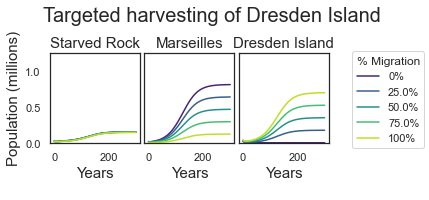

In [11]:
scenarios = []
models = []
labels = []
for red_rate in [0, 0.25, 0.5, 0.75, 1]:
    scen, model = test_mig_harv(red_rate, 0.2)
    scenarios.append(scen)
    models.append(scen)
    labels.append(f'{red_rate*100}%')
graph_results(scenarios, labels, 'Graphics', 'Targeted harvesting of Dresden Island', label_title='% Migration')

# Test Impacts of harvesting in Starved Rock on other populations

In [12]:
def test_starved_harvesting(s_harv):
    mask = node_data['Pool'] == 'c'
    node_data.loc[mask, 'harvest_max'] = s_harv*2
    
    results, model = test_model()
    
    node_data.loc[mask, 'harvest_max'] = 0
    
    return results, model

C:\Users\Cameron\anaconda3\lib\site-packages\metaipm_rerickson_usgs-1.0.0-py3.7.egg\MetaIPM\network.py:173: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
C:\Users\Cameron\anaconda3\lib\site-packages\metaipm_rerickson_usgs-1.0.0-py3.7.egg\MetaIPM\node.py:104: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.


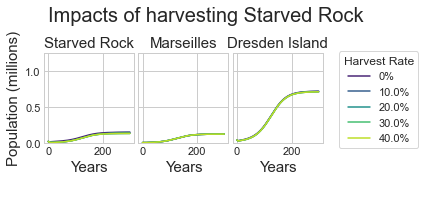

In [13]:
scenarios = []
models = []
labels = []
for s_harv in [0, 0.1, 0.2, 0.3, 0.4]:
    scen, model = test_starved_harvesting(s_harv)
    scenarios.append(scen)
    models.append(scen)
    labels.append(f'{s_harv*100}%')
graph_results(scenarios, labels, 'Graphics', 'Impacts of harvesting Starved Rock', label_title='Harvest Rate')